# Naive Bayes - Who Wrote That?

In [61]:
#System and my modules
import sys
sys.path.append("../tools/")
from colorama import Fore

#Data managment
import pandas as pd 
import numpy as np

#SKlearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#For preprocesing
import string
import re

#Visualization 
import seaborn as sns
import matplotlib.pyplot as plt 

#Requires manual download pip install pystempel
from stempel import StempelStemmer

#Natural language processing tool
import nltk
from nltk.corpus import stopwords

### MY TOOLS FOR MINING CONVERSATIONS ###
import MessFileReader as mfr

## Set Parameters and Get Data

In [62]:
#Set conv ID, it is name of folder in which message_1.json file is located
#conv_id = '!ExampleConv'
conv_id = '!ExampleGroup'
#Minimum number of words message has to have to be taken into account
min_no_words = 10

In [63]:
#Create utility objects from conversation 
conv = mfr.readFile('../data/' + conv_id)
conv_params = mfr.getConvInfo(conv)
messages = mfr.getMessages(conv, ignore_quiters = True)
messages = [mess for mess in messages if 'content' in mess.keys()] #Filter out lack of content
messages = [mess for mess in messages if len(mess['content'].split()) > min_no_words]
print('Messages longer than {} words: {}\n'.format(min_no_words, len(messages)))   

Messages longer than 10 words: 9925



## Prepare Data Frame For Classification
To have efficient classification it is generally good to have balanced dataset.

In [64]:
df_orgin = []
for mess in messages:
    df_orgin.append((mess['content'], mess['sender_name'],))

df = pd.DataFrame(df_orgin, columns = ['text','name']) 
print('Original counts:')
cts = df['name'].value_counts()
min_messages = cts.min()
participants = cts.index.tolist()
print(cts)

#Get indices of messages of each participant
indices = []
for part in participants:
    all_inds = df.index[df['name'] == part]
    #Take amount of smallest number of messages and append indices
    indices.extend(np.random.choice(all_inds, min_messages, replace=False).tolist())

#Balance Data 
data = df.loc[indices] #Get only 
print('\nBalanced counts:')
print(data['name'].value_counts())

#Define features and labels 
features = data['text'].tolist()
labels = data['name'].tolist()

Original counts:
Bartłomiej Cerek    3356
Example Person3     3351
Example Person1     1342
Example Person4      941
Example Person2      935
Name: name, dtype: int64

Balanced counts:
Example Person4     935
Example Person1     935
Example Person2     935
Bartłomiej Cerek    935
Example Person3     935
Name: name, dtype: int64


In [65]:
#Split train/test 
X_train_raw, X_test_raw, y_train, y_test = train_test_split(features, labels, stratify = labels, test_size=0.2)

print('Number of training samples: {}'.format(len(X_train_raw)))
print('Number of test samples: {}'.format(len(X_test_raw)))

Number of training samples: 3740
Number of test samples: 935


## Define Preprocessing Function
Before words will be fed to classifier they have to be processed. Polish language is quite irregular and contains many form of words so **stemmer** will be used to convert words to their basic forms. Also **stop words**, so common words without important meaning, will be deleted.

Unfortunatly used stemmer has very low accuracy. With English results are way better.

In [66]:
stopwordspl = set(stopwords.words('polish.txt'))
stemmer = StempelStemmer.default()

def preprocesString(txt):
    #Use stemming? Parameter not to be set by user, purposly not parameter.
    stem_on = True
    
    #Remove punctuation
    txt = txt.translate(str.maketrans("", "", string.punctuation)).lower()
    #Remove single chars 
    txt = re.sub(r"\b[a-zA-Z]\b", "", txt)
    #Remove numbers 
    txt = re.sub("[\d+]", "", txt)
    
    #Tokenize
    tokens = nltk.word_tokenize(txt)
    tokens = [w for w in tokens if not w in stopwordspl] #Filter from stopwords
    tokens = [w.encode('ascii', 'ignore').decode('ascii') for w in tokens] #Filter from emoji
    tokens = [w for w in tokens if w != ''] #Filter from empty
    tokens = [w for w in tokens if w[:4] != 'http'] #Filter http requests
    
    #Name change before stemming in case stemming is off
    output = tokens
    
    #Stem
    if stem_on:
        output = []
        for t in tokens:
            t_stemmed = stemmer.stem(t)
            if t_stemmed is None or len(t_stemmed) < 3:
                output.append(t)
            else:
                output.append(t_stemmed)
        
    return output

## Create TfIdf Vector From Messages

In [67]:
#Vectorize messages, use preprocessing function.
vect = TfidfVectorizer(sublinear_tf=True,analyzer = preprocesString)
X_train_transf = vect.fit_transform(X_train_raw)
X_test_transf  = vect.transform(X_test_raw)

#See how big is vocabulay of conversation.
vocab = vect.get_feature_names()
print('Vocabulary lenght: {}'.format(len(vocab)))

Vocabulary lenght: 10564


In [68]:
#Delete some features that seem redundant to speed up learning.
selector = SelectPercentile(f_classif, percentile=15)
selector.fit(X_train_transf, y_train)
X_train_transf_sel = selector.transform(X_train_transf)
X_test_transf_sel  = selector.transform(X_test_transf)

print('Features left after reduction: {}'.format(X_train_transf_sel.shape[1]))

Features left after reduction: 1585


## Perform and Evaluate Classification.

Naive Bayes classifier will be used.

Accuracy: 41.18%


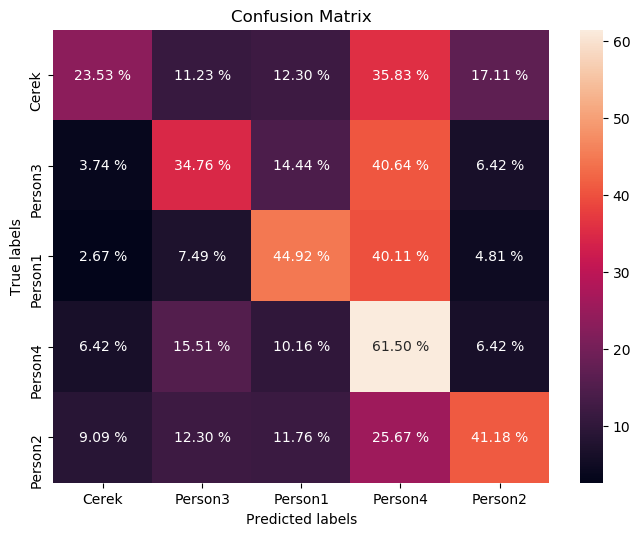

In [69]:
#Classification time baby 
X_train = X_train_transf_sel.toarray()
X_test = X_test_transf_sel.toarray()

clasif = GaussianNB()
clasif.fit(X_train, y_train)
pred = clasif.predict(X_test)
acc = accuracy_score(pred, y_test)
cm = confusion_matrix(y_test, pred, labels = participants)
f = np.sum(cm, axis =1) # scaling factor
cm = cm / f *100

#Visualization
print('Accuracy: {:.2f}%'.format(acc*100))

fig, ax = plt.subplots(figsize=(8,6), dpi = 100)
ax = sns.heatmap(cm, annot=True, ax = ax, fmt='.2f'); #annot=True to annotate cells

# labels, title and ticks
sur_names = [part.split()[1] for part in participants]
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(sur_names)
ax.yaxis.set_ticklabels(sur_names);

for t in ax.texts: t.set_text(t.get_text()  + " %")

In [70]:
#Examples

# ind_corr = np.where(pred == y_test)[0]
# ind_wrng = np.where(~(pred == y_test))[0]

# #Print correct
# print(Fore.GREEN)
# for i in np.random.choice(ind_corr, 3, replace=False):
#     print(pred[i])
#     print(X_test_raw[i], '\n')
    
# print(Fore.RED)
# for i in np.random.choice(ind_wrng, 3, replace=False):
#     print(pred[i])
#     print(X_test_raw[i], '\n')
